# **Thompson Sampling + Restless Multi-Armed Bandits for Maternal Healthcare**

Kritika Prakash  
September 6th, 2021  

## **Thompson Sampling + Restless Multi-Armed Bandits**
- Key question: How to choose which beneficiary to intervene on?
- Limited resource allocation problem
- Offline historical experience
- Limited online feature data

## **1. Pipeline**

## **Pipeline**
- Train data - beneficiary features + intervention trajectory
- Model: restless MAB
- Each arm of the MAB is an MDP representing a disjoint subset of the beneficiaries
- Fix latent transition matrices for active and passive action
- Augmented MDP with auxiliary sleeping states
- Clustering: to group beneficiaries into N groups
- Mapping from features to clusters via Random Forest
- Test data - only has features
- Whittle Index based inference

<img src="1.png">

## **2. Basic Setup**

### **2.1 Restless Multi-Armed Bandits**

N independent 2-action MDPs where each MDP = $\{S, A, R, P\}$
- Non-stationary reward distribution
- Bernoulli reward disitribution
- The reward response not only depends on the arm, but also on the state of each arm. 
- Limited samples for each arm (beneficiary)
- MDP accomodates for sleeping states - to ensure a gap of $ \geq \eta$ timesteps between 2 interventions for the same beneficiary
- Pull m out of N arms 

### **2.2 Current State Transition Model**

Passive action  
- $P(NE, p, E) = x_{1}$  
- $P(E, p, E) = x_{2}$  

Active action  
- $P(NE, a, E) = y_{1}$  
- $P(E, a, E) = y_{2}$  

In [ ]:
# MDP primitives

states = [
          ('S1', 'NE') , ('S1', 'E'), 
          ('S2', 'NE') , ('S2', 'E'), 
          ('S3', 'NE') , ('S3', 'E'), 
          ('A' , 'NE') , ('A' , 'E')
          ]

actions = ['p', 'a']

def reward(state_tuple):
    state = state_tuple[1]
    if state == 'E': # state 1
        return 1.
    return 0.

trans_probs_p = [
                 [ 1 - x1,   # NE -> NE 
                   x1 ],     # NE -> E
                 [ 1 - x2,   # E -> NE
                   x2 ]      # E -> E
                ]
trans_probs_a = [
                 [ 1 - y1,   # NE -> NE
                   y1 ],     # NE -> E
                 [ 1 - y2,   # E -> NE
                   y2 ]      # E -> E
                ]

## **3. Offline Learning**


### **3.1 Passive Transition Probability (PPF) Clustering**
- Clustering based on transition probabilities via the k-means algorithm
- Only use passive action probabilities
- Estimate transition probabilities using the frequency distribution of each cluster

### **3.2 Random Forest Feature Classifier**
- Input: static features
- Output: chosen beneficiary cluster
- This is used to find which cluster a test beneficiary belongs to

### **3.3 Active Intervention Transition Probability Estimation Heuristic**
- For some clusters, we might not be able to estimate the probability of active intervention
- For each $(s,s')$ pair:  
Use the mean difference between active and passive probabilities for all the clusters that have an active probability estimate.  
Add this mean difference to the passive transition probability of the current cluster

## **4. Online Decision Making**

### **4.1 Whittle Index based Inference Heuristic**
Key idea: Find a passive reward subsidy offered along with the passive action reward. Find the infemum (largest lower-bound) subsidy that makes passive action just as rewarding as active action.

- One Whittle index per (cluster, state) pair
- $2*k$ Whittle Indices generated at each time step



### **4.2 Thompson Sampling**

##### **What is it?**
- A Bayesian approach to the bandit problem
- Always chooses the arm with the highest expected reward taking uncertainty into account
- Start with any Bernoulli prior modelled using a Beta distribution
- Sample actions from the beta distribution 
- Choose the action with the highest expected reward
- Update the posterior Beta distribution based on successes/failures

##### **Goal**  
Given observations, minimize regret in time T, find the optimal way of making decisions while learning the state transition model / reward response model.
- This should help achieve the optimal exploration - exploitation trade-off 
- Regret measured by comparing the total reward achieved with the optimal infinite-horizon average reward achievable by playing the optimal policy $\pi^*$


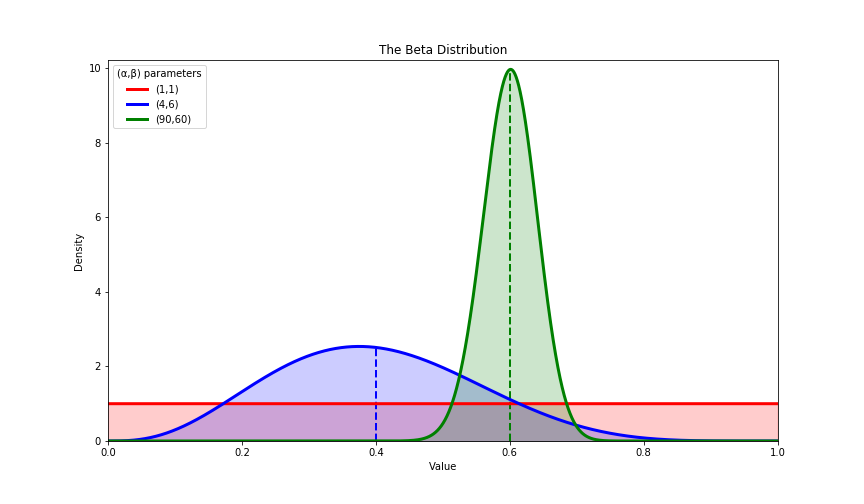

#### **4.2.1 Learn Reward Response Model**

Maintain a belief about the mean of each arm.

##### **Choosing the right prior**

We can assume a uniform prior

##### **Learning the posterior**

- For Bernoulli reward distribution, posterior sampling of rewards is done using Beta distribution
- Shift the distribution to the left if you observe a 0, and to the right if you observe a 1. 
- Uniform Distribution - Beta(1,1)  
- Prior: Beta($\alpha, \beta$)  
- Posterior:  
Beta($\alpha + 1, \beta$) if we observe 1  
Beta($\alpha, \beta + 1$) if we observe 0  

##### **Choosing an action**

Play the arm with the highest probability of being the best arm
In round t for each arm i,   
- Posterior = Beta($S_{i, t} + 1, F_{i, t} + 1$)
- Sample $\theta_{i, t}$ from each posterior
- Play arm $i_{t} = \max_{i} \theta_{i, t}$

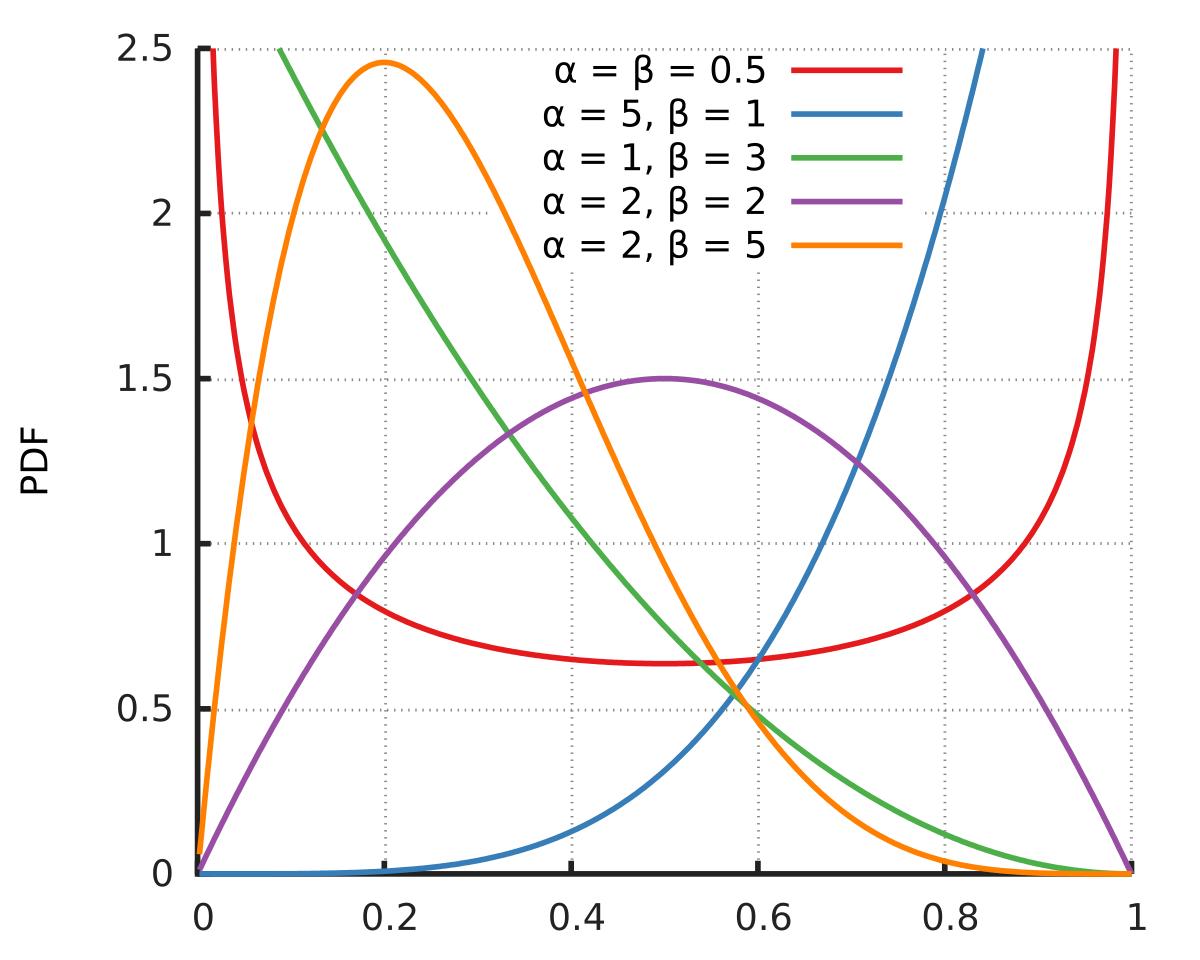

#### **4.2.2 Learn State Transition Model**
Unknown transition dynamics. We start with a prior transition matrix distribution.

##### **Choosing the right prior**
- Flat / uninformative prior - this does not give us any information
- Learn from frequency distribution of each cluster (MDP) is a single instance of the transition dynamics.

##### **Learning the posterior**

Posterior Sampling for transitions using Dirichlet distribution. 
- Maintain a Dirichlet distribution for $P(s,a)$ for each $(s,a)$ pair.
- After round $t$, after observing $s_{t+1}$, update the distribution for $(s_{t}, a_{t})$.
- Dirichlet distribution is the multinomial version of the Beta distribution
- N parameters (number of states)
- Update each parameter by counting the number of state visits

##### **Choosing an action**

Sample a $P(s,a)$ function for every $s, a$ pair. Compute the optimal policy $\pi$ for every sample MDP, and use that policy. 

## **5. Applying Thompson Sampling to RMABs**

In our case, we need to learn and update all transition matrix posteriors across all MDPs
- Parametric model for each MDP's state transition function
- Posterior update frequency
- Minimum number of samples required for a meaningful update

## **6. Prior Work**

- Regret Bounds for Thompson Sampling in Episodic Restless Bandit Problems

### **Regret Bounds for Thompson Sampling in Episodic Restless Bandit Problems**

- General policy map to define the competitor
- Reward Response Model
- Finite time horizon problem
- Updates posterior + System resets at the end of each episode
- POMDP: Learner can only observe the rewards and states of active arms
- Benchmark (fixed) deterministic policy mapping $\mu$  
Input: parameter $\theta$  
Output: deterministic policy $\pi = \mu (\theta)$  
- Use Benchmark deterministic policy to calculate Bayesian Regret  

$$R(T | \theta^{*}) = m . \textbf{E}_{\theta^{*}, \pi^{*}} [ \Sigma_{j=i}^{L} A_{j} X_{j} | H ] - \textbf{E}_{\theta^{*}} \Sigma_{t=1}^{T} A_{t} X_{t} $$

- Episode length L
- Active arms A
- History H
- Active rewards X
- Number of episodes m
- Select N out of K arms

<img src="0.png">

## **7. Thompson Sampling Implementation in Collapsing Bandits Code**

Link to code: https://github.com/AdityaMate/collapsing_bandits/blob/c3532f5b4bc1512434e9fc9765779e78bdffa7c9/code/adherence_simulation.py#LC447
 

In [10]:
def thompson_sampling(N, priors, counts, random_stream):

    T_hat = np.zeros((N,2,2,2))
    for i in range(N):
        for j in range(T_hat.shape[1]):
            for k in range(T_hat.shape[2]):
                params = priors[i, j, k, :] + counts[i, j, k, :]
                T_hat[i, j, k, :] = random_stream.dirichlet(params)
    return T_hat

def thompson_sampling_constrained(N, priors, counts, random_stream):

    T_hat = np.zeros((N,2,2,2))
    for i in range(N):
        # While sampled T_hat is not valid or has not been sampled yet...
        while (not verify_T_matrix(T_hat[i]) or T_hat[i].sum() == 0):
            for j in range(T_hat.shape[1]):
                for k in range(T_hat.shape[2]):
                    params = priors[i, j, k, :] + counts[i, j, k, :]
                    T_hat[i, j, k, :] = random_stream.dirichlet(params)
    return T_hat

## **8. References**
0. Mining Restless Multi-Armed Bandits from Real Data for Improving Maternal and Child Health Outcomes
1. Thompson Sampling for Learning in Online Decision Making: https://www.youtube.com/watch?v=o6HBIGzQfJs  
2. Regret Bounds for Thompson Sampling in Episodic Restless Bandit Problems: https://arxiv.org/pdf/1905.12673.pdf
3. Regret Bounds for Thompson Sampling in Restless Bandit Problems: https://realworld-sdm.github.io/paper/10.pdf
4. A Tutorial on Thompson Sampling: https://djrusso.github.io/RLCourse/papers/TS_Tutorial.pdf

# **Thank You**

Kritika Prakash   
September 6th, 2021